In [1]:
# Need data to be zero mean and scaled???

# Stochastic algorithm 3

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from sklearn import datasets  # to retrieve the iris Dataset
import pandas as pd  # to load the dataframe
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps#float32
import control

# ID
from __future__ import division

from past.utils import old_div

# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *

import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt

In [2]:
# Load spike data
spike_data = np.load('../data/KPCA_proj_10k.npy')                      
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(spike_data)) #scaling the data
print(scaled_data.shape)
scaled=pd.DataFrame.to_numpy(scaled_data)
scaled_r = scaled[0:20,:]

(289, 10000)


In [3]:
print(scaled_r.shape)

(20, 10000)


In [4]:
# Hankel Matrices i>n and j -> \infty
def Hankel(data,h,w):
    p = data.shape[0]
    J = w # 500
    I = h  # double
    Y = np.empty([2*I*p,J])

    for i in range(2*I):
        Y[i*(p):(i+1)*p,:] = data[:,i:J+i]
    
    print(Y.shape)
    return Y

In [5]:
p = scaled_r.shape[0]
I = 30
J = 5000
Y = Hankel(scaled_r,I,J)
Yp = Y[:I*p,:]
Yf = Y[I*p:,:]

Ypp = Y[:(I+1)*p,:]
yff = Y[(I+1)*p:,:]
print(Yp.shape)
print(Yf.shape)
print(Ypp.shape)
print(yff.shape)

(1200, 5000)
(600, 5000)
(600, 5000)
(620, 5000)
(580, 5000)


In [6]:
def Project(A,B):
    return A@B.T@np.linalg.pinv(B@B.T)@B 

In [7]:
Oi = Project(Yf,Yp)
oi = Project(yff,Ypp)

In [8]:
W1 = np.eye(p*I)
W2 = np.eye(J)
O = W1@Oi@W2
print(Oi.shape)
print(O.shape)

(600, 5000)
(600, 5000)


In [9]:
U, s, VT = np.linalg.svd(O, full_matrices=False)

(600,)


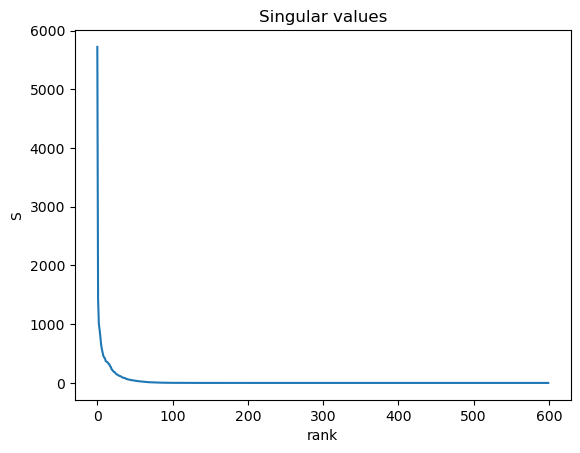

In [10]:
print(s.shape)
fig, ax = plt.subplots()
ax.plot(s)

ax.set(xlabel='rank', ylabel='S',
       title='Singular values')
plt.show()

In [11]:
# get r from svd
r = 25
U_r = U[:,:r]
S_r = np.diag(s[:r,])

In [12]:
Gi = U_r@sc.linalg.sqrtm(S_r)
gi = Gi[:-p,:]
Xhat = np.linalg.pinv(Gi)@Oi
XXhat = np.linalg.pinv(gi)@oi
Yi = Yf[:p,:]

In [13]:
A = XXhat@np.linalg.pinv(Xhat)
C = Yi@np.linalg.pinv(Xhat)

In [14]:
# residuals
rho_w = XXhat - A@Xhat
rho_v = Yi - C@Xhat
rho =  np.concatenate((rho_w, rho_v), axis=0)
print(rho.shape)
Cov = np.cov(rho)
print(Cov.shape)

(45, 5000)
(45, 45)


In [15]:
Q = Cov[:30,:30]
R = Cov[-20:,-20:]
SS = Cov[:30,-20:]
print(SS.shape)

(30, 20)


In [16]:
#Sig = scipy.linalg.solve_discrete_lyapunov(A,Q)
#G = A@Sig@C.T + SS
#Gam_0 = C@Sig@C.T + R

#P = scipy.linalg.solve_discrete_are(A.T,)


In [17]:
#K,P,E = control.dlqe(A,np.eye(r),C,Q,R)

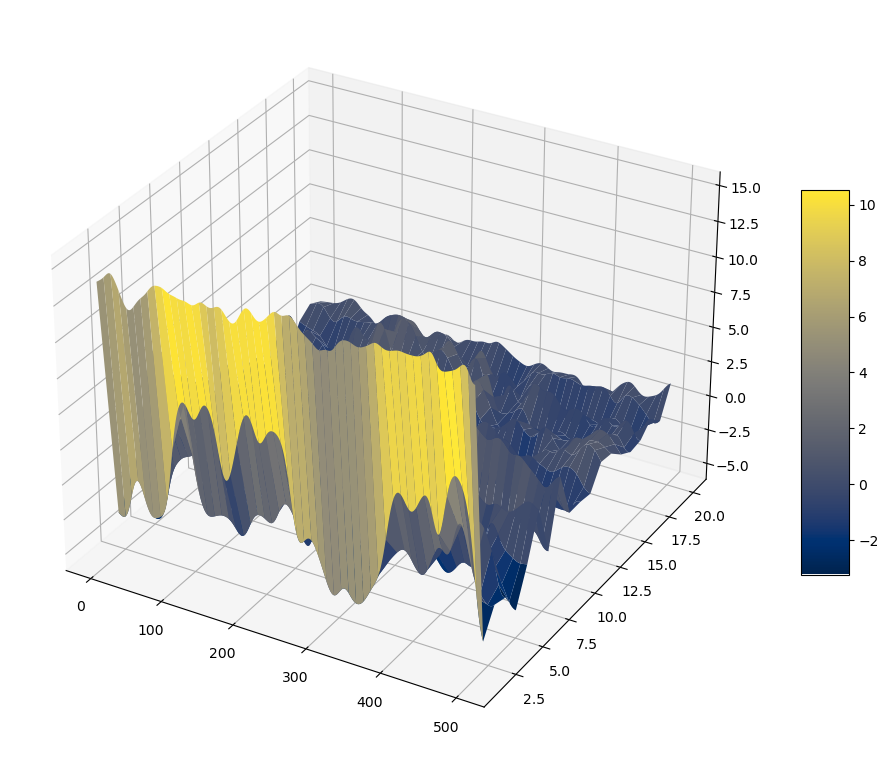

In [18]:
# orignal data projected
t = 500
time = np.linspace(1, t, t)
neurons = np.linspace(1, p, p)
T, N = np.meshgrid(time, neurons)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(T, N, scaled_r[:,0:t], cmap = plt.cm.cividis)


fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

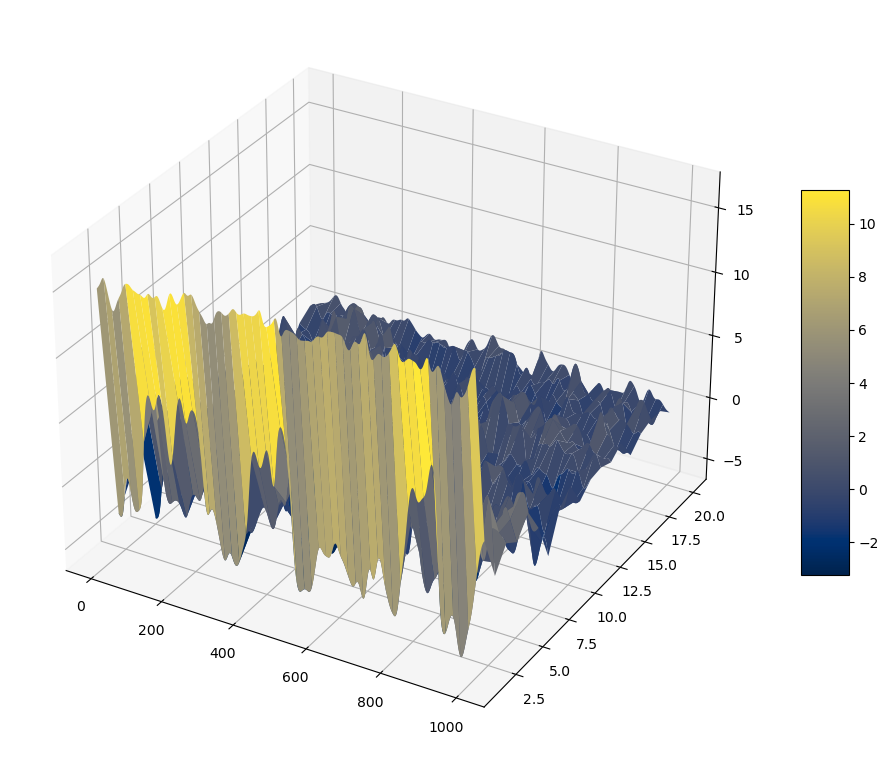

In [19]:
# orignal data projected
t = 1000
time = np.linspace(1, t, t)
neurons = np.linspace(1, p, p)
T, N = np.meshgrid(time, neurons)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(T, N, spike_data[0:p,0:t], cmap = plt.cm.cividis)


fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()
    

In [20]:
# Forecast
tt = 100
x = np.zeros([r,tt])
x[:,0] = Xhat[:,0]
y = np.zeros([p,tt])

for i in range(tt-1):
    y[:,i+1] = C@x[:,i]
    x[:,i+1] = A@x[:,i]
    
    

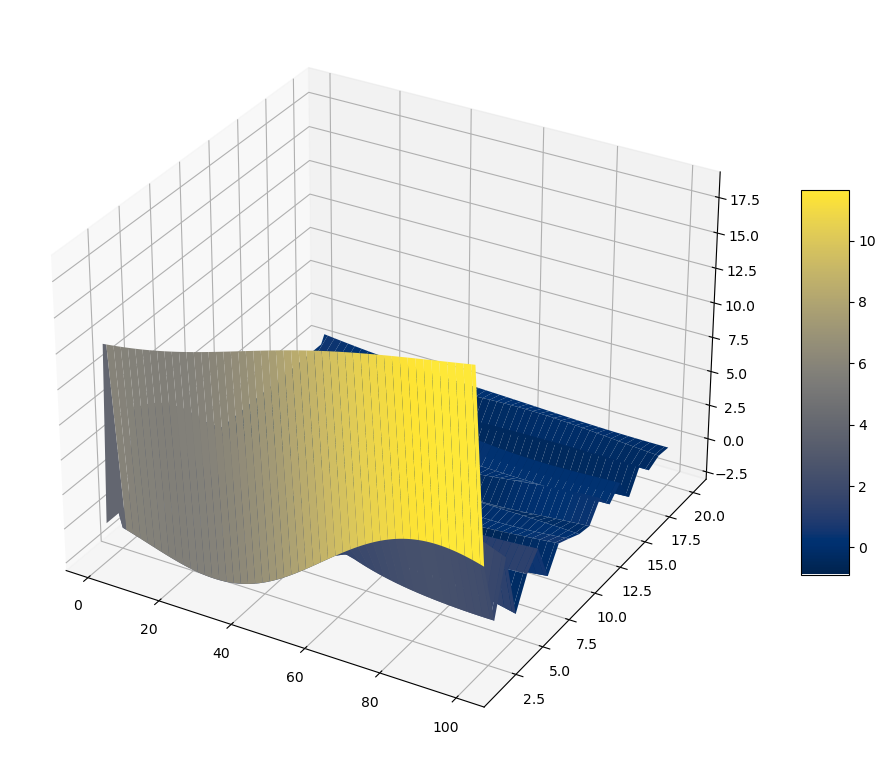

In [21]:
# Forecast cost
t = tt
time = np.linspace(1, t, t)
neurons = np.linspace(1, p, p)
T, N = np.meshgrid(time, neurons)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(T, N, y, cmap = plt.cm.cividis)


fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()
    

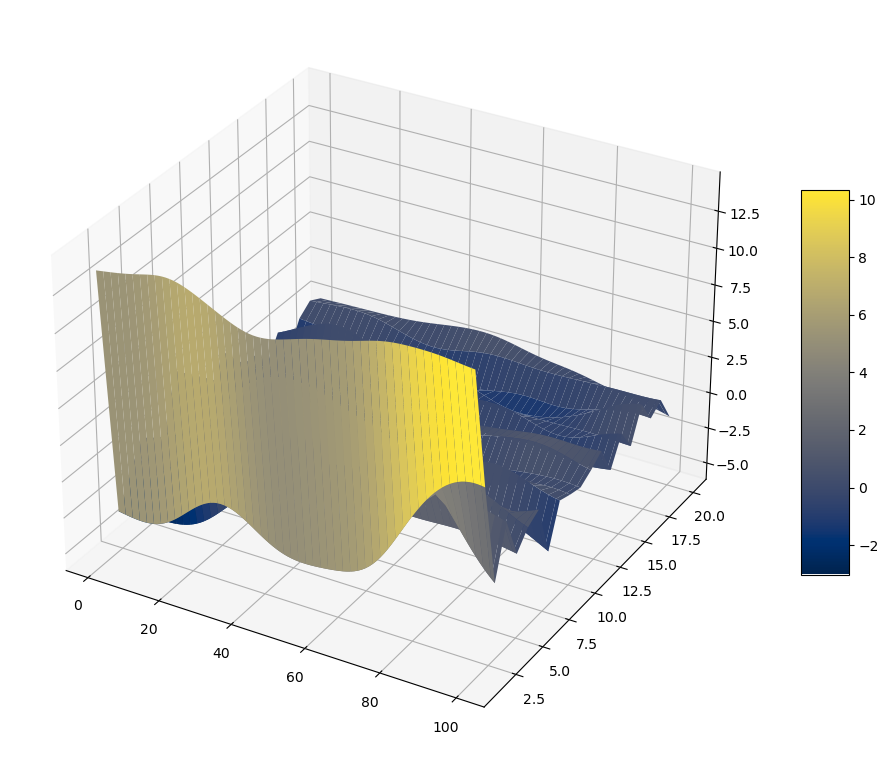

In [22]:
# orignal data projected
t = tt
time = np.linspace(1, t, t)
neurons = np.linspace(1, p, p)
T, N = np.meshgrid(time, neurons)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(T, N, scaled_r[0:p,0:t], cmap = plt.cm.cividis)


fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

In [23]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
from matplotlib import cm

%matplotlib qt
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Original data')
time = np.linspace(1, t, t)
neurons = np.linspace(1, p, p)
T, N = np.meshgrid(time, neurons)


#surf = ax.plot_surface(T, N, spike_data[:,0:1000], cmap = plt.cm.cividis)
surf = ax.plot_surface(T, N, y, cmap = plt.cm.cividis)

fig.colorbar(surf, shrink=0.5, aspect=8)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('prediction data')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
surf = ax.plot_surface(T, N, scaled_r[0:p,0:t], cmap = plt.cm.cividis)
fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()